# Purpose of this notebook

This notebook provides code for building a Dutch to English translator using a vanilla transformer.<br>
It uses code from the following sources:

https://www.tensorflow.org/text/guide/subwords_tokenizer <br>
https://www.tensorflow.org/text/tutorials/transformer <br>
https://machinelearningmastery.com/save-load-keras-deep-learning-models/<br>

The vanilla transformer was presented in the paper 'Attention is all you need' published by Vashwani et al. (2017) at ArXiv (https://arxiv.org/abs/1706.03762). The architecture is shown in the following image:

<img src="images/transformer.png">

The dataset is taken from ParaCrawl (https://paracrawl.eu/) available through tensorflow datasets (https://www.tensorflow.org/datasets/catalog/para_crawl).
The model is trained on a single NVIDIA 3090 GPU.

# Prepare environment for use of GPU and install tensorflow
Source: (https://www.tensorflow.org/install/pip)<br><br>
<u>Create conda environment:<br></u>
conda create --name tf python=3.9 <br>
conda activate tf <br><br>
<u>check if nvidia gpu driver is installed:<br></u>
nvidia-smi <br><br>
<u>If needed, install nvidia gpu driver:</u><br>
https://www.nvidia.com/Download/index.aspx<br><br>
<u>install cuda and cudnn:<br></u>
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 <br><br>
<u>Configure system paths:</u><br>
mkdir -p \\$CONDA_PREFIX/etc/conda/activate.d <br>
echo 'export LD_LIBRARY_PATH=\\$LD_LIBRARY_PATH:\\$CONDA_PREFIX/lib/' > $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh <br><br>
<u> Install tensorflow:<br></u>
pip install --upgrade pip <br>
pip install tensorflow <br><br>
<u>Some troubleshooting: <br></u>
https://stackoverflow.com/questions/44232898/memoryerror-in-tensorflow-and-successful-numa-node-read-from-sysfs-had-negativ <br>
https://forums.developer.nvidia.com/t/could-not-load-dynamic-library-libnvinfer-so-7/231606/7<br>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR) # exclude certain non-essential error messages

2023-01-12 21:39:58.763185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices('GPU')) # check if GPU is recognized

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load dataset

In [3]:
examples, metadata = tfds.load('para_crawl/ennl', as_supervised=True, with_info=True)
print(metadata)

tfds.core.DatasetInfo(
    name='para_crawl',
    full_name='para_crawl/ennl/1.2.0',
    description="""
    Web-Scale Parallel Corpora for Official European Languages.
    """,
    config_description="""
    Translation dataset from English to nl.
    """,
    homepage='https://paracrawl.eu/releases.html',
    data_path='/home/user/tensorflow_datasets/para_crawl/ennl/1.2.0',
    file_format=tfrecord,
    download_size=400.63 MiB,
    dataset_size=1.40 GiB,
    features=Translation({
        'en': Text(shape=(), dtype=string),
        'nl': Text(shape=(), dtype=string),
    }),
    supervised_keys=('en', 'nl'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5659268, num_shards=16>,
    },
    citation="""@misc {paracrawl,
        title  = "ParaCrawl",
        year   = "2018",
        url    = "http://paracrawl.eu/download.html."
    }""",
)


2023-01-12 21:39:59.855042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 21:40:00.186713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20999 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [4]:
# to limit size of dataset use 90% for training, 10% for validation

train_examples, train_metadata = tfds.load('para_crawl/ennl', split='train[:90%]',
                                     as_supervised=True, with_info=True)
print(tf.data.experimental.cardinality(train_examples).numpy()) # elements

5093341


In [5]:
val_examples, val_metadata = tfds.load('para_crawl/ennl', split='train[90%:]',
                                     as_supervised=True, with_info=True)
print(tf.data.experimental.cardinality(val_examples).numpy()) # elements

565927


In [6]:
# look at first three training examples

i = 0
for example in train_examples:
    print(example[0])
    print(example[1])
    i += 1
    if i==3:
        break

tf.Tensor(b'In the romantically decorated chambre of the Hotel de France the guests are welcomed by a well-stocked fridge, which seems invite you to have a crazy night.', shape=(), dtype=string)
tf.Tensor(b'In de romantisch ingerichte chambre van Hotel de France worden de gasten verwelkomd door een gul gevulde ijskast die uit lijkt te nodigen tot een dolle avond.', shape=(), dtype=string)
tf.Tensor(b'"Very well," answered my uncle; "let us start from that point and count four days\' storm, during which our rate cannot have been less than eighty leagues in the twenty-four hours."', shape=(), dtype=string)
tf.Tensor(b'"Goed! Dan zullen wij van dat punt uitgaan en vier dagen storm rekenen, gedurende welke onze snelheid niet minder dan tachtig uur per dag heeft kunnen bedragen." "Dat geloof ik ook.', shape=(), dtype=string)
tf.Tensor(b'Price tag 15 nights / 16 days, including top luxury accommodation, air-conditioned car and experienced driver, English-speaking guide, domestic flights in I

In [7]:
# split training set into Dutch and English
train_nl = train_examples.map(lambda en, nl: nl) # for en, nl in train_examples select nl
train_en = train_examples.map(lambda en, nl: en)


# Create vocabulary

In [8]:
# using BERT tokenizer to turn the texts into tokens

bert_tokenizer_params=dict(lower_case=True)  # turn text into lowercase
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 32000,   # size of en fr word piece vocabulary used in attention is all you need paper
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Start arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    # https://www.programcreek.com/python/?code=tensorflow%2Ftext%2Ftext-master%2Ftools%2Fwordpiece_vocab%2Fwordpiece_tokenizer_learner_lib.py
    # takes in wordcounts (list of (string, int) tuples), returns wordpiece vocabulary
    learn_params={},
)


In [9]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

The bert_vocab_from_dataset algorithm is described here:
https://www.tensorflow.org/text/guide/subwords_tokenizer#algorithm

In [10]:
# # !run this cell only once!
# # creates Dutch and English vocabularies, takes some time to run (~86 minutes in my case)

# nl_vocab = bert_vocab.bert_vocab_from_dataset(
#      train_nl.batch(1000).prefetch(2),
#      **bert_vocab_args
# )
# en_vocab = bert_vocab.bert_vocab_from_dataset(
#      train_en.batch(1000).prefetch(2),
#      **bert_vocab_args
# )


# # Check some elements of Dutch vocab
# print(nl_vocab[:10])
# print(nl_vocab[1000:1100])
# print(nl_vocab[-10:])

# # write vocabularies to disk, no need to construct them again
# def write_vocab_file(filepath, vocab):
#   with open(filepath, 'w') as f:
#     for token in vocab:
#       print(token, file=f)

# write_vocab_file('en_vocab.txt', en_vocab)
# write_vocab_file('nl_vocab.txt', nl_vocab)


# Build tokenizer

In [11]:
import tensorflow_text as text

In [12]:
# explore tokenization with BertTokenizer

nl_tokenizer = text.BertTokenizer('nl_vocab.txt', **bert_tokenizer_params)
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

for en_examples, nl_examples in train_examples.batch(3).take(1): # key is (en, nl)
    for ex in nl_examples:
        print(ex.numpy())
    print('\n')
    # Tokenize the examples -> (batch, word, word-piece)
    token_batch = nl_tokenizer.tokenize(nl_examples)
    # Merge the word and word-piece axes -> (batch, tokens)
    token_batch = token_batch.merge_dims(-2,-1)
    for ex in token_batch.to_list():
        print(ex)

b'In de romantisch ingerichte chambre van Hotel de France worden de gasten verwelkomd door een gul gevulde ijskast die uit lijkt te nodigen tot een dolle avond.'
b'"Goed! Dan zullen wij van dat punt uitgaan en vier dagen storm rekenen, gedurende welke onze snelheid niet minder dan tachtig uur per dag heeft kunnen bedragen." "Dat geloof ik ook.'
b'15 nachten / 16 dagen, inclusief Engelssprekende gids, luxe-wagen met airconditioning en chauffeur, verplaatsingen, luxe accommodatie, alle ontbijten, lunches en avondmalen, inkomticketen en de activiteiten die in het overzicht vermeld worden.'


[701, 696, 7512, 2880, 11234, 2578, 9063, 697, 753, 696, 2956, 718, 696, 1474, 8980, 717, 700, 48, 4688, 12091, 30032, 708, 730, 1567, 705, 7414, 724, 700, 12799, 1146, 2004, 17]
[5, 749, 4, 733, 803, 758, 697, 709, 1681, 7518, 698, 1164, 927, 7110, 5053, 15, 1542, 992, 744, 1821, 714, 983, 733, 8886, 935, 830, 820, 732, 746, 6821, 17, 5, 5, 709, 1634, 719, 726, 17]
[909, 3887, 18, 1037, 927, 15, 1439

In [13]:
# explore how to re-assemble words from extracted tokens

words = nl_tokenizer.detokenize(token_batch)
tf.strings.reduce_join(words, separator=' ', axis=-1)


<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'in de romantisch ingerichte chambre van hotel de france worden de gasten verwelkomd door een gul gevulde ijskast die uit lijkt te nodigen tot een dolle avond .',
       b'" goed ! dan zullen wij van dat punt uitgaan en vier dagen storm rekenen , gedurende welke onze snelheid niet minder dan tachtig uur per dag heeft kunnen bedragen . " " dat geloof ik ook .',
       b'15 nachten / 16 dagen , inclusief engelssprekende gids , luxe - wagen met airconditioning en chauffeur , verplaatsingen , luxe accommodatie , alle ontbijten , lunches en avondmalen , inkomticketen en de activiteiten die in het overzicht vermeld worden .'],
      dtype=object)>

In [14]:
# explore how to add start and end tokens to examples for tokenization
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

add_start_end(token_batch)

<tf.RaggedTensor [[2, 701, 696, 7512, 2880, 11234, 2578, 9063, 697, 753, 696, 2956, 718, 696,
  1474, 8980, 717, 700, 48, 4688, 12091, 30032, 708, 730, 1567, 705, 7414,
  724, 700, 12799, 1146, 2004, 17, 3]                                       ,
 [2, 5, 749, 4, 733, 803, 758, 697, 709, 1681, 7518, 698, 1164, 927, 7110,
  5053, 15, 1542, 992, 744, 1821, 714, 983, 733, 8886, 935, 830, 820, 732,
  746, 6821, 17, 5, 5, 709, 1634, 719, 726, 17, 3]                        ,
 [2, 909, 3887, 18, 1037, 927, 15, 1439, 1736, 23266, 794, 2114, 15, 1494,
  16, 3731, 703, 1595, 698, 4953, 15, 16369, 739, 15, 1494, 1225, 15, 743,
  15316, 15, 3932, 1149, 698, 2004, 19129, 15, 701, 6852, 7621, 6495, 698,
  696, 1170, 708, 701, 699, 916, 2710, 718, 17, 3]                        ]>

In [15]:
import re

In [16]:
# explore how to remove reserved tokens during detokenization

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [17]:
nl_examples.numpy()


array([b'In de romantisch ingerichte chambre van Hotel de France worden de gasten verwelkomd door een gul gevulde ijskast die uit lijkt te nodigen tot een dolle avond.',
       b'"Goed! Dan zullen wij van dat punt uitgaan en vier dagen storm rekenen, gedurende welke onze snelheid niet minder dan tachtig uur per dag heeft kunnen bedragen." "Dat geloof ik ook.',
       b'15 nachten / 16 dagen, inclusief Engelssprekende gids, luxe-wagen met airconditioning en chauffeur, verplaatsingen, luxe accommodatie, alle ontbijten, lunches en avondmalen, inkomticketen en de activiteiten die in het overzicht vermeld worden.'],
      dtype=object)

In [18]:
token_batch = nl_tokenizer.tokenize(nl_examples).merge_dims(-2,-1)
token_batch_start_end = add_start_end(token_batch)
words = nl_tokenizer.detokenize(token_batch_start_end)
words

<tf.RaggedTensor [[b'[START]', b'in', b'de', b'romantisch', b'ingerichte', b'chambre',
  b'van', b'hotel', b'de', b'france', b'worden', b'de', b'gasten',
  b'verwelkomd', b'door', b'een', b'gul', b'gevulde', b'ijskast', b'die',
  b'uit', b'lijkt', b'te', b'nodigen', b'tot', b'een', b'dolle', b'avond',
  b'.', b'[END]']                                                         ,
 [b'[START]', b'"', b'goed', b'!', b'dan', b'zullen', b'wij', b'van',
  b'dat', b'punt', b'uitgaan', b'en', b'vier', b'dagen', b'storm',
  b'rekenen', b',', b'gedurende', b'welke', b'onze', b'snelheid', b'niet',
  b'minder', b'dan', b'tachtig', b'uur', b'per', b'dag', b'heeft',
  b'kunnen', b'bedragen', b'.', b'"', b'"', b'dat', b'geloof', b'ik',
  b'ook', b'.', b'[END]']                                                 ,
 [b'[START]', b'15', b'nachten', b'/', b'16', b'dagen', b',', b'inclusief',
  b'engelssprekende', b'gids', b',', b'luxe', b'-', b'wagen', b'met',
  b'airconditioning', b'en', b'chauffeur', b',', b

In [19]:
cleanup_text(reserved_tokens, words).numpy()


array([b'in de romantisch ingerichte chambre van hotel de france worden de gasten verwelkomd door een gul gevulde ijskast die uit lijkt te nodigen tot een dolle avond .',
       b'" goed ! dan zullen wij van dat punt uitgaan en vier dagen storm rekenen , gedurende welke onze snelheid niet minder dan tachtig uur per dag heeft kunnen bedragen . " " dat geloof ik ook .',
       b'15 nachten / 16 dagen , inclusief engelssprekende gids , luxe - wagen met airconditioning en chauffeur , verplaatsingen , luxe accommodatie , alle ontbijten , lunches en avondmalen , inkomticketen en de activiteiten die in het overzicht vermeld worden .'],
      dtype=object)

In [20]:
import pathlib

In [21]:
# now define the customized tokenizer used to tokenize the texts

class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    # create tokenizer based on vocab located at vocab_path
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    # ["[PAD]", "[UNK]", "[START]", "[END]"]
    self._reserved_tokens = reserved_tokens
    # include vocab file in saved tokenizer model
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    # load vocab
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    # turn vocab into tf.Variable
    self.vocab = tf.Variable(vocab)

    # signatures serve to identify inputs and outputs of a function when building a model
    # these are included in the graph
    # get_concrete_function traces the graph, @tf.function runs the graph

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)


In [22]:
# Build customtokenizers to be used

tokenizers = tf.Module()
tokenizers.nl = CustomTokenizer(reserved_tokens, 'nl_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')



In [23]:
# save customtokenizers as a tokenizer model

tokenizer_model_name = 'tokenizer_model_paracrawl_en_nl_translator'
tf.saved_model.save(tokenizers, tokenizer_model_name)

In [24]:
# see methods of tokenizer model module
[item for item in dir(tokenizers.en) if not item.startswith('_')]


['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'name',
 'name_scope',
 'non_trainable_variables',
 'submodules',
 'tokenize',
 'tokenizer',
 'trainable_variables',
 'variables',
 'vocab',
 'with_name_scope']

In [25]:
# reload model and test methods

reloaded_tokenizers = tf.saved_model.load(tokenizer_model_name)
reloaded_tokenizers.nl.get_vocab_size().numpy()

30872

In [26]:
tokens = reloaded_tokenizers.nl.tokenize(['Hallo TensorFlow!'])
tokens.numpy()


array([[    2,  6735,   955, 20622, 25838,     4,     3]])

In [27]:
text_tokens = reloaded_tokenizers.nl.lookup(tokens)
text_tokens


<tf.RaggedTensor [[b'[START]', b'hallo', b'ten', b'##sor', b'##flow', b'!', b'[END]']]>

In [28]:
# archive the tokenizer model
!zip -r {tokenizer_model_name}.zip {tokenizer_model_name}


/bin/bash: /home/user/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
updating: tokenizer_model_paracrawl_en_nl_translator/ (stored 0%)
updating: tokenizer_model_paracrawl_en_nl_translator/variables/ (stored 0%)
updating: tokenizer_model_paracrawl_en_nl_translator/variables/variables.data-00000-of-00001 (deflated 49%)
updating: tokenizer_model_paracrawl_en_nl_translator/variables/variables.index (deflated 32%)
updating: tokenizer_model_paracrawl_en_nl_translator/assets/ (stored 0%)
updating: tokenizer_model_paracrawl_en_nl_translator/assets/nl_vocab.txt (deflated 54%)
updating: tokenizer_model_paracrawl_en_nl_translator/assets/en_vocab.txt (deflated 51%)
updating: tokenizer_model_paracrawl_en_nl_translator/saved_model.pb (deflated 91%)
updating: tokenizer_model_paracrawl_en_nl_translator/fingerprint.pb (stored 0%)


# Set up data pipeline

In [29]:
# import matplotlib.pyplot as plt
# import numpy as np

# # check the number of tokens per example in the dataset, takes some time (~6 minutes in my case)
# # only needs to be run once to determine MAX_TOKENS

# lengths = []

# for en_examples, nl_examples in train_examples.batch(1024): # key is (en, nl)
#     nl_tokens = tokenizers.nl.tokenize(nl_examples)
#     lengths.append(nl_tokens.row_lengths())
    
#     en_tokens = tokenizers.en.tokenize(en_examples)
#     lengths.append(en_tokens.row_lengths())

# # show the distribution of the number of tokens per example and the maximum

# all_lengths = np.concatenate(lengths)

# plt.figure(figsize=(14, 6))
# plt.hist(all_lengths, np.linspace(0, 400, 101))
# plt.xticks(np.arange(0, 400, 10))
# plt.ylim(plt.ylim())

# max_length = max(all_lengths)
# plt.plot([max_length, max_length], plt.ylim())
# plt.title(f'Maximum tokens per example: {max_length}');


In [30]:
# the paper attention is all you need indicates batches were used with around 25,000 tokens
# to fit into memory of 1 NVIDIA 3090 GPU here the maximum length of tokens is set to 128 with a batch size of 64

MAX_TOKENS=128
BATCH_SIZE=64

# setting buffer size for shuffling
BUFFER_SIZE = 50000


In [31]:
# set up input pipeline

def prepare_batch(en, nl):
    nl = tokenizers.nl.tokenize(nl)      # Output is ragged.
    nl = nl[:, :MAX_TOKENS]              # Trim to MAX_TOKENS.
    nl = nl.to_tensor()                  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (nl, en_inputs), en_labels   # nl, en text switched

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


In [32]:
# test input pipeline

for (nl, en_inputs), en_labels in train_batches.take(1):
    break
    
print(nl.shape)
print(en_inputs.shape)
print(en_labels.shape)
print(reloaded_tokenizers.nl.lookup(nl))
print(reloaded_tokenizers.en.lookup(en_inputs))

(64, 65)
(64, 66)
(64, 66)
tf.Tensor(
[[b'[START]' b'veel' b'toeristen' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'laboratorium' b'##apparatuur' ... b'[PAD]' b'[PAD]'
  b'[PAD]']
 [b'[START]' b'u' b'krijgt' ... b'[PAD]' b'[PAD]' b'[PAD]']
 ...
 [b'[START]' b'gemiddeld' b'komt' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'virtuele' b'wandeling' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'het' b'derde' ... b'[PAD]' b'[PAD]' b'[PAD]']], shape=(64, 65), dtype=string)
tf.Tensor(
[[b'[START]' b'many' b'tourists' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'laboratory' b'equipment' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'you' b'also' ... b'[PAD]' b'[PAD]' b'[PAD]']
 ...
 [b'[START]' b'on' b'average' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'virtual' b'tour' ... b'[PAD]' b'[PAD]' b'[PAD]']
 [b'[START]' b'third' b'level' ... b'[PAD]' b'[PAD]' b'[PAD]']], shape=(64, 66), dtype=string)


# Encoder

This is the left part of the transformer.<br>
<img src="images/encoder.png" width="300" align="left"/>


# Positional encoding

For the input embedding a Keras Embedding layer will be used.<br>

The positional encoding is calculated according to the following formula:

<img src="images/positional_encoding.png" width="300" align="left"/>

In [33]:
import numpy as np

In [34]:
def positional_encoding(max_len, d_model):
    '''
    Returns positional encoding for maximum length and embedding of tokenized sentences
    '''
    
    positions = np.arange(max_len)[:, np.newaxis]                      # shape = (max_len, 1)
    i = np.arange(d_model)[np.newaxis, :]//2                           # shape = (1, d_model)
    angle_rads = positions / np.power(10000, 2*i/np.float32(d_model))  # shape = (max_len, d_model)
    
    # apply sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]                          # shape = (batch_size, max_len, d_model)

    return tf.cast(pos_encoding, dtype=tf.float32)


The encoder layer will use Keras MultiHeadAttention and LayerNormalization layers.<br>
The FeedForward layer can be defined as follows:

In [35]:
def FeedForward(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # ouput shape = (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)                  # output shape = (batch_size, seq_len, d_model)
    ])

Now the EncoderLayer can be built, which will be used N times in the encoder.<br>
Its MultiHeadAttention layer implements attention which follows this formula:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\
$$
<br>


The output of the embedding layer has dimensions (batch_size, input_seq_len, d_model). The dimensions of $QK^T$ is (batch_size, input_seq_len, input_seq_len). This means that the padding mask M, used to exclude padding from influencing the softmax calculation, also has dimension (batch_size, input_seq_len, input_seq_len. 

In [36]:
def create_padding_mask(seq):
    '''
    Creates attention_mask for MultiHeadAttention layer.
    Returns a tensor in which 1 indicates attention and 0 indicates no attention.
    Arguments:
        seq -- attention logits of dimension (batch_size, seq_len)
    Returns:
        padding_mask of dimension (batch_size, 1, seq_len)
    '''    
    
    seq = tf.cast(tf.math.not_equal(seq, 0), tf.bool)

    return seq[:, tf.newaxis, :]   # shape (batch_size, 1, seq_len). New axis can be broadcast to seq_len.

In [37]:
# example
create_padding_mask([[32, 64, 87, 5, 368, 0, 0],
                     [675, 54, 23, 0, 0, 0, 0]])

<tf.Tensor: shape=(2, 1, 7), dtype=bool, numpy=
array([[[ True,  True,  True,  True,  True, False, False]],

       [[ True,  True,  True, False, False, False, False]]])>

In [38]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer consists of a multi-head self-attention layer followed by a feed forward layer.
    A residual connection exists around each sub-layer. 
    This connection is added to the output of the sub-layer, followed by layer normalization.
    """

    def __init__(self, d_model, h, dff, p_drop=0.1, layernorm_eps=1e-6):
        
        '''
        d_model -- encoding dimension of the model
        h -- number of heads used in MultiHeadAttention layer
        dff -- number of nodes in first Dense layer of FeedForward layer
        p_drop -- dropout ratio
        layernorm_eps -- value added to denominator in calculation of norm, for numerical stability
        '''

        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=h, key_dim=d_model, dropout=p_drop)

        self.ffn = FeedForward(d_model=d_model, dff=dff)

        self.layernorm = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(p_drop)
    
    def call(self, x, training, enc_padding_mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- tensor of shape (batch_size, input_seq_len, d_model)
            enc_padding_mask -- Boolean mask to ensure padding is not treated as input
            training -- Boolean, if set to true activates dropout
        Returns:
            encoder_layer_out -- tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
                
        attn_output = self.mha(query=x, value=x, key=x, attention_mask=enc_padding_mask, training=training) 
        # shape = (batch_size, input_seq_len, d_model)
        
        # apply layer normalization on sum of the input and the attention output
        out = self.layernorm(Add()([x, attn_output]))

        # pass out through a feed forward layer
        ffn_output = self.ffn(out)
        
        # apply dropout layer to ffn output during training
        ffn_output =  self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization on sum of out1 and ffn_output
        encoder_layer_out = self.layernorm(Add()([out, ffn_output]))
        
        return encoder_layer_out


In [40]:
from tensorflow.keras.layers import Embedding, Dropout

In [41]:
class Encoder(tf.keras.layers.Layer):
    """
    The Encoder passes the input to an embedding layer, adds positional encoding, 
    and passes the resulting tensor through a stack of encoder layers.
        
    """  
    def __init__(self, input_vocab_size, d_model, max_len, N, h, dff, p_drop=0.1, layernorm_eps=1e-6):
        
        '''
        Arguments:
            input_vocab_size -- size of the vocabulary of the input text, int
            d_model -- dimension of the embedding of the model, int
            max_len -- maximum length of any input sequence
            N -- number of encoding layers, int
            h -- number of attention heads per multihead attention layer, int
            dff = dimension of fully connected layer
            p_drop -- rate of random dropout of elements after each sublayer
            layernorm_eps = value added to denominator in calculation of norm, for numerical stability
        '''

        super(Encoder, self).__init__()

        self.embedding = Embedding(input_vocab_size, d_model) # creates lookup table with shape (input_vocab_size, d_model)
        self.d_model = d_model
        
        self.pos_encoding = positional_encoding(max_len, self.d_model)

        self.dropout = Dropout(p_drop)

        self.N = N

        self.enc_layers = [EncoderLayer(d_model=self.d_model, h=h, dff=dff, p_drop=p_drop, layernorm_eps=layernorm_eps)
                           for _ in range(self.N)]
        
    def call(self, x, training, enc_padding_mask):
        """
        Forward pass of the Encoder
        
        Arguments:
            x -- tensor of shape (batch_size, input_seq_len)
            training -- boolean, if true activates dropout
            enc_padding_mask -- boolean mask to ensure that padding is not treated as input
        Returns:
            x -- tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)          # output shape = (batch_size, input_seq_len, d_model)

        # Scale embedding by multiplying it with the square root of d_model to enhance performance
        x *= tf.sqrt(tf.cast(self.d_model, float))

        # Add position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]

        # Pass encoded embedding through dropout layer
        x = self.dropout(x, training=training)

        # Pass output through stack of encoding layers 
        for i in range(self.N):
            x = self.enc_layers[i](x, training, enc_padding_mask)

        return x

# Decoder

This is the right part of the transformer.<br>

<img src="images/decoder.png" width="300" align="left"/>

In the decoder, the outputs are shifted right with regard to the inputs. This is done in the data pipeline where \<SOS> is dropped from the inputs while it is retained in the outputs.<br>
After adding positional encoding, in multihead attention a 'causal mask' is added masking out tokens that are still to be predicted. This way, only the tokens that were already predicted in a previous step, or the preceding tokens that are provided during training, become the basis for the relevant query from the decoder to be used on the encoder output. 

In [42]:
def create_causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((1, seq_len, seq_len), tf.bool), -1, 0)
    return mask  # (1, seq_leng, seq_len)

In [43]:
# example
create_causal_mask(4)

<tf.Tensor: shape=(1, 4, 4), dtype=bool, numpy=
array([[[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]]])>

In [44]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, d_model, h, dff, p_drop=0.1, layernorm_eps=1e-6):

        super(DecoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(num_heads=h, key_dim=d_model, dropout=p_drop)
        
        self.ffn = FeedForward(d_model, dff)
        
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        
        self.dropout = tf.keras.layers.Dropout(p_drop)
        
    def call(self, x, enc_output, training, causal_mask, dec_padding_mask, enc_padding_mask):

        attn1 = self.mha(query=x, value=x, key=x, attention_mask=causal_mask & dec_padding_mask)  
        attn1 = self.dropout(attn1, training=training)
        out1 = self.layernorm(Add()([x + attn1]))
    
        attn2 = self.mha(query=out1, value=enc_output, key=enc_output, attention_mask=enc_padding_mask)
        attn2 = self.dropout(attn2, training=training)
        out2 = self.layernorm(Add()([out1, attn2]))

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout(ffn_output, training=training)
        out3 = self.layernorm(Add()([out2, ffn_output]))

        return out3

In [45]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, d_model, max_len, N, h, dff, target_vocab_size, p_drop = 0.1, layernorm_eps = 1e-6):

        super(Decoder, self).__init__()

        self.d_model = d_model

        self.N = N

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(max_len, self.d_model)

        self.dropout = tf.keras.layers.Dropout(p_drop)

        self.dec_layers = [DecoderLayer(d_model=d_model, h=h, dff=dff, p_drop=p_drop,
                                    layernorm_eps = layernorm_eps)
                       for _ in range(self.N)]

    def call(self, x, enc_output, training, causal_mask, dec_padding_mask, enc_padding_mask):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)              # output shape = (batch_size, target_seq_len, d_model)

        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        x += self.pos_encoding[:, :seq_len,:]

        x = self.dropout(x, training=training)

        for i in range(self.N):
            x = self.dec_layers[i](x, enc_output, training, causal_mask, dec_padding_mask, enc_padding_mask)

        return x


# Transformer

<img src="images/transformer.png">

In [46]:
class Transformer(tf.keras.Model):
    def __init__(self, input_vocab_size, d_model, max_len, N , h, dff, target_vocab_size, p_drop = 0.1,
                 layernorm_eps = 1e-6):

        super().__init__()

        self.encoder = Encoder(input_vocab_size = input_vocab_size, d_model = d_model, max_len = max_len,
                               N = N, h = h, dff = dff, p_drop = p_drop, layernorm_eps = layernorm_eps)
    
        self.decoder = Decoder(d_model = d_model, max_len = max_len, N = N, h = h, dff = dff,
                               target_vocab_size = target_vocab_size, p_drop = p_drop, layernorm_eps = layernorm_eps)
    
        self.linear_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inputs, training):

        enc_inputs, dec_inputs = inputs
        
        enc_padding_mask, causal_mask, dec_padding_mask = self.create_masks(enc_inputs, dec_inputs)
    
        enc_output = self.encoder(enc_inputs, training, enc_padding_mask)
    
        dec_output = self.decoder(dec_inputs, enc_output, training, causal_mask, dec_padding_mask, enc_padding_mask)

        logits = self.linear_layer(dec_output)
    
        # return output of linear layer of decoder (before softmax)

        return logits

    def create_masks(self, enc_inputs, dec_inputs):
        
        enc_padding_mask = create_padding_mask(enc_inputs)
        
        causal_mask = create_causal_mask(tf.shape(dec_inputs)[1])

        dec_padding_mask = create_padding_mask(dec_inputs)
            
        return enc_padding_mask, causal_mask, dec_padding_mask


# Set hyperparameters

In [47]:
N = 6                 # number of layers
d_model = 512         # embedding dimension of model
max_len = MAX_TOKENS  # maximum length of any input sequence
dff = 2048            # number of nodes of feedforward layer
h = 8                 # number of heads
p_drop = 0.1          # dropout rate


In [48]:
transformer = Transformer(
    input_vocab_size=tokenizers.nl.get_vocab_size().numpy(),
    d_model = d_model,
    max_len = max_len,
    N = N,
    h = h,
    dff=dff,
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    p_drop=p_drop)


In [49]:
output = transformer((nl, en_inputs))

2023-01-12 21:40:05.554229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [50]:
print(nl.shape)
print(en_inputs.shape)
print(output.shape)

(64, 65)
(64, 66)
(64, 66, 31222)


In [51]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  78819328  
                                                                 
 decoder (Decoder)           multiple                  78998528  
                                                                 
 dense_24 (Dense)            multiple                  16016886  
                                                                 
Total params: 173,834,742
Trainable params: 173,834,742
Non-trainable params: 0
_________________________________________________________________


# Set learning rate schedule

The following learning rate schedule is used to train the model:
<img src="images/learning_rate.png">

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = tf.cast(d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [53]:
ValueError: Unknown layer: 'Transformer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


In [54]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Train Step')

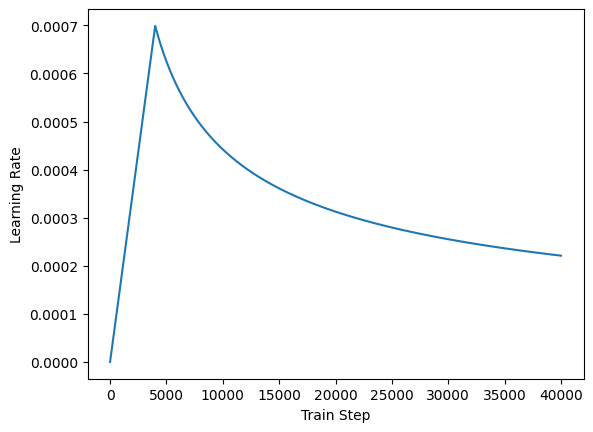

In [55]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')


# Set up loss and metrics

In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [57]:
def masked_loss(label, pred):
    mask = label != 0
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [58]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])


In [59]:
# 1 epoch takes around 11 hours on 1 NVIDIA GeForce RTX 3090 GPU. Steps taken 79,584

transformer.fit(train_batches,
                epochs=1,
                validation_data = val_batches)


2023-01-12 21:40:17.005128: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d38fce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-12 21:40:17.005151: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-12 21:40:17.009200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-12 21:40:17.086826: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79584/79584 [==============================] - 37184s 467ms/step - loss: 4.3922 - masked_accuracy: 0.3419 - val_loss: 6.3373 - val_masked_accuracy: 0.1311


In [60]:
class Translator(tf.Module):

    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Dutch, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
          sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.nl.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
          output = tf.transpose(output_array.stack())
          predictions = self.transformer([encoder_input, output], training=False)

          # Select the last token from the `seq_len` dimension.
          predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

          predicted_id = tf.argmax(predictions, axis=-1)

          # Concatenate the `predicted_id` to the output which is given to the
          # decoder as its input.
          output_array = output_array.write(i+1, predicted_id[0])

          if predicted_id == end:
            break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)

        return text, tokens


In [61]:
translator = Translator(tokenizers, transformer)


In [62]:
sentence = 'eens kijken of dit goed vertaald wordt.'
ground_truth = 'let\'s see if this is translated correctly.'

translated_text, translated_tokens = translator(
    tf.constant(sentence))



In [63]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

print_translation(sentence, translated_text, ground_truth)

Input:         : eens kijken of dit goed vertaald wordt.
Prediction     : the following is the result :
Ground truth   : let's see if this is translated correctly.


In [66]:
# The result is not great. Ways to increase accuracy could include: 
# check for bugs, train multiple epochs, improve the dataset, adjust hyperparameters, add layers

In [70]:
transformer_json = transformer.to_json()
with open("transformer.json", "w") as json_file:
    json_file.write(transformer_json)
# serialize weights to HDF5
transformer.save_weights("transformer.h5")
print("Saved model to disk")

Saved model to disk
